# Practical week 9: custom data loaders, a CNN from scratch and visualising loss curves

The practical this week focusses on some low level practical issues that you will need to tackle in the assessment. We will see how to take an arbitrary dataset and write a custom data loader so that we can request random mini-batches during training like we did last week. Then you'll design and train your own CNN to learn a classification problem on the data. Working through this whole practical is great practice for the assessment.

## This week's dataset

The task this week is to classify clothing images according to the type of garment. For this task, we're using the Fashion MNIST dataset. It's exactly the same format as the MNIST digits dataset we used last week (60k training images, 10k test images, 10 possible class labels, grayscale images of size $28\times 28$). See the code below for descriptions of the 10 classes.

Fashion MNIST is already set up as a dataset in PyTorch. However, we're going to pretend it's not so that you can experience writing your own custom data loader.

The following code will download and uncompress the training and testing datasets, then load them as PyTorch tensors. You'll have to do the rest.

In [4]:
import torch
import os
import torchvision.datasets as datasets
from torch.utils.data import Dataset

classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]
datafolder = "data/"
os.makedirs(datafolder, exist_ok=True)

url = "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/"
files = [
    "train-images-idx3-ubyte",
    "train-labels-idx1-ubyte",
    "t10k-images-idx3-ubyte",
    "t10k-labels-idx1-ubyte",
]
for f in files:
    datasets.utils.download_and_extract_archive(url + f + ".gz", datafolder)
data_train = datasets.mnist.read_image_file(datafolder + files[0])
labels_train = datasets.mnist.read_label_file(datafolder + files[1])
data_test = datasets.mnist.read_image_file(datafolder + files[2])
labels_test = datasets.mnist.read_label_file(datafolder + files[3])

Using downloaded and verified file: data/train-images-idx3-ubyte.gz
Extracting data/train-images-idx3-ubyte.gz to data/
Using downloaded and verified file: data/train-labels-idx1-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz to data/
Using downloaded and verified file: data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz to data/
Using downloaded and verified file: data/t10k-labels-idx1-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz to data/


The raw data is now loaded into tensors. Let's check we're happy with the shapes and contents.

In [5]:
print("TRAINING DATA")
print(data_train.shape)
print("Minimum value: {}".format(data_train.min()))
print("Maximum value: {}".format(data_train.max()))
print(data_train.dtype)
print("TRAINING LABELS")
print(labels_train.shape)
print("Minimum value: {}".format(labels_train.min()))
print("Maximum value: {}".format(labels_train.max()))

TRAINING DATA
torch.Size([60000, 28, 28])
Minimum value: 0
Maximum value: 255
torch.uint8
TRAINING LABELS
torch.Size([60000])
Minimum value: 0
Maximum value: 9


Do the shapes of the two tensors make sense to you? One important note: we're storing the images currently as 8 bit integers to save space but we'll need to switch to floats for each mini-batch for training.

## Custom data loaders

`torch.utils.data.Dataset` is an abstract class for representing a dataset. To write a custom data loader you need to inherit `Dataset` and override two methods:

- `__len__` such that `len(dataset)` returns the number of elements in the dataset
- `__getitem__` such that `dataset[i]` can be used to get the $i$th element from the dataset

You can use the `__init__` constructor to set up your data. There are two common ways of constructing a data loader:

1. Read the entire dataset into memory inside `__init__`. If the dataset isn't too big so that you can hold the whole thing in memory then this is a good idea since `__getitem__` won't need to read anything from disc. (This option is fine for the dataset in this practical).
2. For larger datasets, `__init__` is just used to initialise where the dataset is stored and perhaps to read the labels into memory but no actual input data is loaded at this point. Then when `__getitem__` is called you actually load that specific item (for example an image) from disc.

Anything that `__len__` or `__getitem__` need access to should be stored in `self`.

**To do**:

Create a custom dataset whose constructor takes as input a size $n\times 28 \times 28$ tensor of images and size $n$ tensor of class labels. `__getitem__` should return a single image of size $1\times 28 \times 28$ as a 32 bit float scaled between 0 and 1 (hint: `x.float()/255` converts `x` from 8 bit integers to 0..1 floats) and the corresponding class label.

In [6]:
class FashionMNISTDataset(Dataset):
    """Custom Fashion MNIST dataset."""

    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    # Your code goes here

    def __len__(self):
        return len(self.labels)

    # Your code goes here

    def __getitem__(self, idx):
        image_unscaled = self.data[idx]
        image = (image_unscaled.float() / 255).unsqueeze(0)
        label = self.labels[idx]
        return image, label


train_data = FashionMNISTDataset(data_train, labels_train)
test_data = FashionMNISTDataset(data_test, labels_test)

Let's test whether your dataset is behaving as expected.

torch.Size([1, 28, 28])


Text(0.5, 1.0, 'Ankle boot')

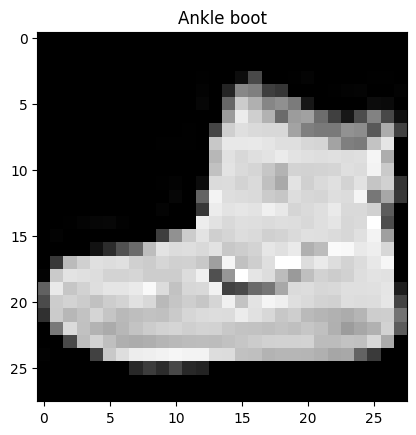

In [7]:
from matplotlib import pyplot as plt

image, label = train_data[0]
print(image.shape)  # should be 1 x 28 x 28
plt.imshow(image.squeeze(0), cmap="gray")
plt.title(classes[label])

Now we can create dataloaders from your two datasets.

In [8]:
batch_size = 50
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size, shuffle=True
)

Let's test them. Do these sizes look right?

In [9]:
images, labels = next(iter(train_loader))
print(images.shape)
print(labels.shape)

torch.Size([50, 1, 28, 28])
torch.Size([50])


## Visualising the dataset

**To do**:

Look at last week's practical and copy the code for visualing images from a mini-batch. Run it with your dataloader to inspect the data. Now modify it so that it prints class descriptions as given above rather than class IDs.

## Create a CNN

**To do**:

Now create a CNN to try to solve this classification problem. You could use the LeNet architecture from the last practical, the mini VGG I gave in my model solution or invent your own from scratch. Maybe you want to try batchnorm layers or even a residual block.

In [10]:
loss_func = torch.nn.CrossEntropyLoss()

In [19]:
# class CNN(nn.Module):
#     def __init__(self):
#         super(CNN, self).__init__()
#         # Your code goes here...
#
#     def forward(self, x):
#         # Your code goes here...
#         pass


# Instantiate the model - this initialises all weights and biases
relu = torch.nn.ReLU()
model = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3, stride=1, padding=1),
    relu,
    torch.nn.BatchNorm2d(3),
    torch.nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1),
    relu,
    torch.nn.BatchNorm2d(3),
    torch.nn.MaxPool2d(kernel_size=2, stride=2),
    torch.nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, padding=1),
    relu,
    torch.nn.BatchNorm2d(6),
    torch.nn.Conv2d(in_channels=6, out_channels=6, kernel_size=3, padding=1),
    relu,
    torch.nn.BatchNorm2d(6),
    torch.nn.MaxPool2d(kernel_size=2, stride=2),
    torch.nn.Flatten(),
    torch.nn.Linear(6 * 7 * 7, 16),
    relu,
    torch.nn.Linear(16, len(classes)),
).to("mps")

# Decide what loss function to use


class ResidualBlock(torch.nn.Module):
    def __init__(self, conv_block_1, conv_block_2, conv_block_3, activation):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv_block_1
        self.conv2 = conv_block_2
        self.conv3 = conv_block_3
        self.activation = activation

    def forward(self, x):
        x_copy = x.clone()
        x = self.conv1(x)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.activation(x)
        x = self.conv3(x)
        x = self.activation(x)
        x = x + x_copy
        x = self.activation(x)
        return x


model = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=1, out_channels=24, kernel_size=3, stride=1, padding=1),
    torch.nn.BatchNorm2d(24),
    ResidualBlock(
        torch.nn.Conv2d(
            in_channels=24, out_channels=24, kernel_size=1, stride=1, padding=0
        ),
        torch.nn.Conv2d(
            in_channels=24, out_channels=48, kernel_size=3, stride=1, padding=1
        ),
        torch.nn.Conv2d(
            in_channels=48, out_channels=24, kernel_size=1, stride=1, padding=0
        ),
        relu,
    ),
    ResidualBlock(
        torch.nn.Conv2d(
            in_channels=24, out_channels=48, kernel_size=1, stride=1, padding=0
        ),
        torch.nn.Conv2d(
            in_channels=48, out_channels=96, kernel_size=3, stride=1, padding=1
        ),
        torch.nn.Conv2d(
            in_channels=96, out_channels=24, kernel_size=1, stride=1, padding=0
        ),
        torch.nn.ReLU(),
    ),
    ResidualBlock(
        torch.nn.Conv2d(
            in_channels=24, out_channels=48, kernel_size=1, stride=1, padding=0
        ),
        torch.nn.Conv2d(
            in_channels=48, out_channels=192, kernel_size=3, stride=1, padding=1
        ),
        torch.nn.Conv2d(
            in_channels=192, out_channels=24, kernel_size=1, stride=1, padding=0
        ),
        torch.nn.ReLU(),
    ),
    torch.nn.AvgPool2d(kernel_size=28, stride=1),
    torch.nn.Flatten(),
    torch.nn.Linear(24, 16),
    relu,
    torch.nn.Linear(16, len(classes)),
).to("mps")

In [2]:
import torchvision

torchvision.models.resnet18()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

It's interesting to see how many learnable parameters your model has in total:

In [15]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(total_params)

147114


Let's put a mini-batch through your CNN, compute a loss and check everything looks ok.

In [20]:
images, labels = next(iter(train_loader))
output = model(images.to("mps"))
print(output.shape)
loss = loss_func(output, labels.to("mps"))
print(loss)

torch.Size([50, 10])
tensor(2.3583, device='mps:0', grad_fn=<NllLossBackward0>)


## Visualisation and training

It's time to train your network. But this time we are going to visualise loss at every iteration and classification accuracy at every epoch for both the training and testing sets. Run the code below then execute the code cell underneath to plot the training curves.

In [21]:
import math

num_epochs = 40

# Set up the optimiser
optim = torch.optim.Adam(model.parameters(), lr=0.01)

# Initialise some variables for computing and tracking stats
iterations_per_epoch = math.ceil(len(train_data) / batch_size)
training_losses = []
training_accuracies = []
testing_losses = []
testing_accuracies = []
for epoch in range(num_epochs):
    # One epoch on the training set
    total_loss = 0
    correct = 0
    total = 0
    total_loss = 0
    for i, (inputs, labels) in enumerate(train_loader):
        # Pass mini-batch through model
        output = model(inputs.to("mps"))
        loss = loss_func(output, labels.to("mps"))
        optim.zero_grad()
        loss.backward()
        optim.step()
        # Find the predicted classes and check accuracy
        pred_y = torch.argmax(output, 1)
        correct += (pred_y == labels.to("mps")).sum()
        total += float(labels.size(0))
        total_loss += loss * images.shape[0]
        # if (i + 1) % 100 == 0:
        #     print(
        #         "Epoch [{}/{}], Iteration [{}/{}], Loss: {:.4f}".format(
        #             epoch + 1, num_epochs, i + 1, iterations_per_epoch, loss.item()
        #         )
        #     )
    total_loss /= len(train_data)
    training_losses.append(total_loss.item())
    training_accuracies.append((correct / total).cpu())
    print(
        "Train accuracy over epoch {}: {:.4f}".format(
            epoch + 1, training_accuracies[-1]
        )
    )

    # One epoch on the test set
    correct = 0
    total = 0
    # Switch to evaluation mode
    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            output = model(images.to("mps"))
            loss = loss_func(output, labels.to("mps"))
            pred_y = torch.argmax(output, 1)
            correct += (pred_y == labels.to("mps")).sum()
            total += float(labels.size(0))
            total_loss += loss * images.shape[0]
        test_accuracy = correct / total
    total_loss /= len(test_data)
    testing_losses.append(total_loss.item())
    # Switch back to training mode
    model.train()
    testing_accuracies.append(test_accuracy.cpu())
    print("Test accuracy at epoch {}: {:.4f}".format(epoch + 1, test_accuracy))

Train accuracy over epoch 1: 0.5928
Test accuracy at epoch 1: 0.7204
Train accuracy over epoch 2: 0.7605
Test accuracy at epoch 2: 0.7719
Train accuracy over epoch 3: 0.8046
Test accuracy at epoch 3: 0.7959
Train accuracy over epoch 4: 0.8282
Test accuracy at epoch 4: 0.8173
Train accuracy over epoch 5: 0.8347
Test accuracy at epoch 5: 0.7995
Train accuracy over epoch 6: 0.8485
Test accuracy at epoch 6: 0.8363
Train accuracy over epoch 7: 0.8592
Test accuracy at epoch 7: 0.8564
Train accuracy over epoch 8: 0.8617
Test accuracy at epoch 8: 0.8602
Train accuracy over epoch 9: 0.8672
Test accuracy at epoch 9: 0.8390
Train accuracy over epoch 10: 0.8661
Test accuracy at epoch 10: 0.8556
Train accuracy over epoch 11: 0.8695
Test accuracy at epoch 11: 0.8682
Train accuracy over epoch 12: 0.8736
Test accuracy at epoch 12: 0.8436
Train accuracy over epoch 13: 0.8724
Test accuracy at epoch 13: 0.8185
Train accuracy over epoch 14: 0.8755
Test accuracy at epoch 14: 0.8671
Train accuracy over epoc

KeyboardInterrupt: 

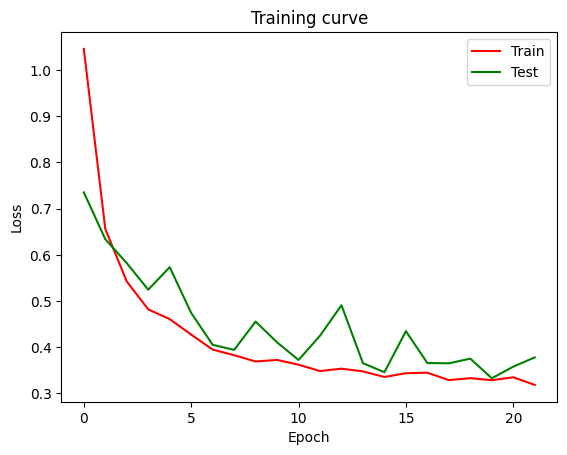

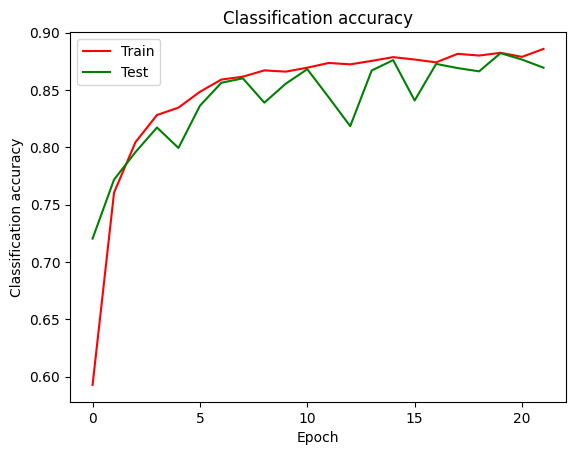

In [22]:
import matplotlib.pyplot as plt

plt.title("Training curve")
plt.plot(range(len(training_losses)), training_losses, "r", label="Train")
plt.plot(range(len(testing_losses)), testing_losses, "g", label="Test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.title("Classification accuracy")
plt.plot(range(len(training_accuracies)), training_accuracies, "r", label="Train")
plt.plot(range(len(testing_accuracies)), testing_accuracies, "g", label="Test")
plt.xlabel("Epoch")
plt.ylabel("Classification accuracy")
plt.legend()
plt.show()

What do you make of the plots? Has training converged yet? Is your model too powerful? (i.e. is overfitting happening?) Or not powerful enough? (Performance not improving much). Tweak your model or hyperparameters if you think there's a problem.

**To do**:

- Try plotting training loss at every iteration rather than just every epoch. Why does it look so different?
- Reuse the visualisation code from last week to show example images along with their correct/estimate class.
- You've probably noticed that training is starting to take a while. Try switching to using a GPU (see lecture slides for instructions).




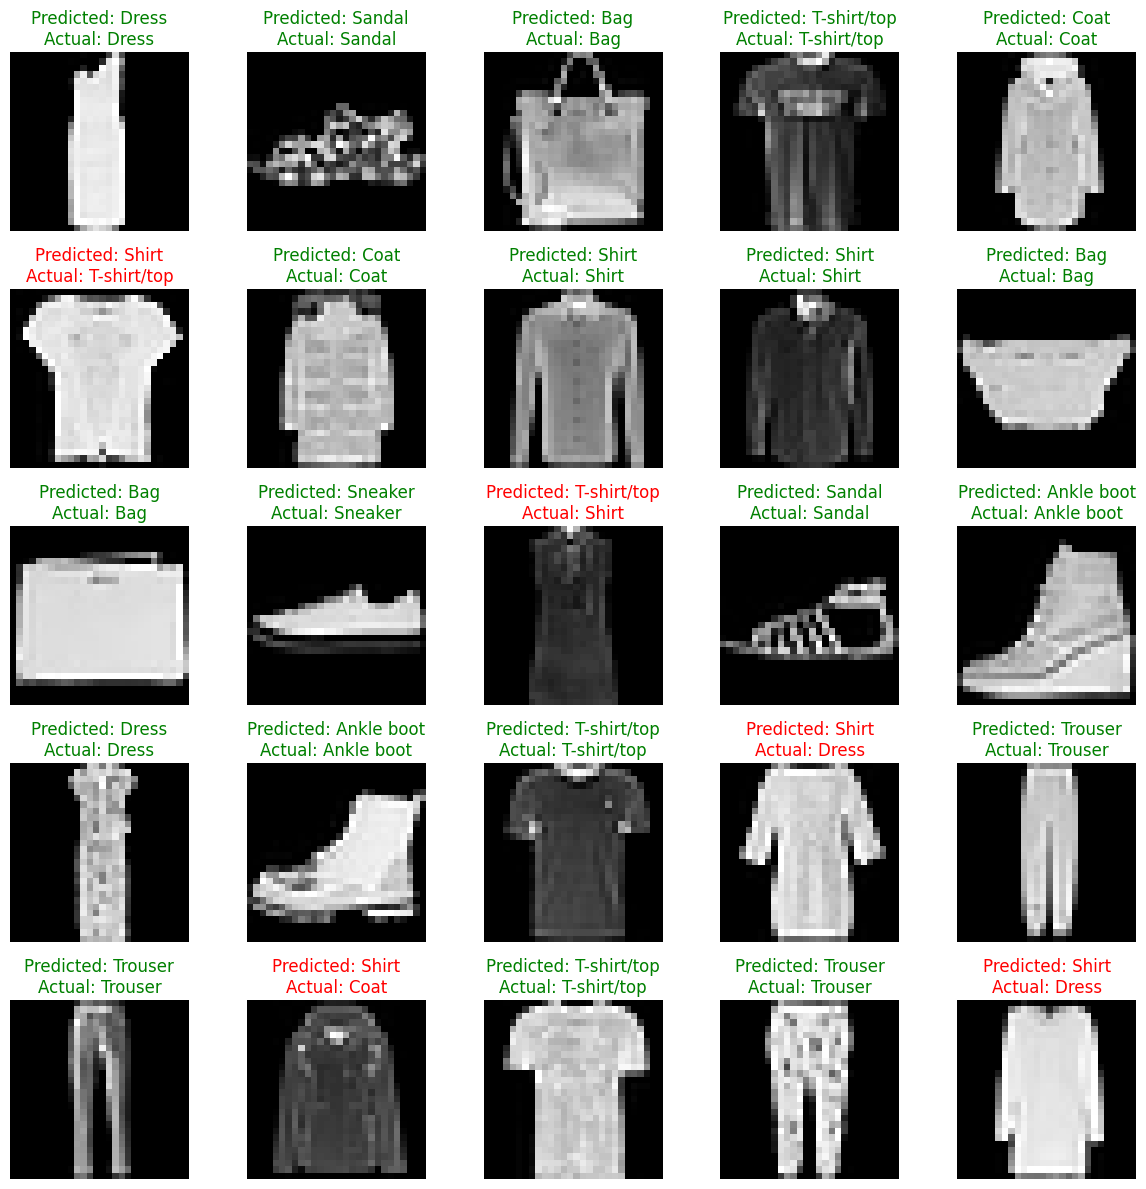

In [24]:
fig = plt.figure(figsize=(12, 12))
imgs, labels = next(iter(test_loader))
predictions = torch.argmax(model(imgs.to("mps")), 1)
for idx, (img, label, prediction) in enumerate(
    zip(imgs[0:25], labels[0:25], predictions[0:25])
):
    fig.add_subplot(5, 5, idx + 1)
    plt.title(
        f"Predicted: {classes[prediction]}\nActual: {classes[label]}",
        color="green" if prediction == label else "red",
    )
    plt.axis("off")
    plt.imshow(img.squeeze(0), cmap="gray")
fig.tight_layout()  # improve spacing